In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import csv
from skimage.feature import hog
from sklearn import svm
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('train.csv', delimiter=',')

In [3]:
df_test = pd.read_csv('test.csv', delimiter=',')

In [4]:
# classication y
y_train = [ d[0] for d in df.values]

In [5]:
train = [ d[1:] for d in df.values ]

In [6]:
test = [ d for d in df_test.values ]

In [14]:
# train and validation
yy_train = y_train[:21000]
yy_valid = y_train[21000:]

In [7]:
# Original image
image_ori = [np.reshape(d, (28, 28)) for d in train]
image_ori = np.uint8(image_ori)

In [8]:
# Image deskewing
SZ = 28
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR
def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img

In [192]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (7,7)
cellSize = (7,7)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
useSignedGradients = True
 
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,
                        nbins,derivAperture,winSigma,histogramNormType,
                        L2HysThreshold,gammaCorrection,nlevels, useSignedGradients)

In [193]:
# Training data
# Reshape
train_shape = np.array([np.reshape(d, (28, 28)) for d in train] )
train_shape = np.uint8(train_shape)

In [27]:
# Training data
# Denoising by thresholding
image_train = [cv2.threshold(deskew(d),127,255,cv2.THRESH_OTSU)[1] /255
               for d in train_shape]
image_train = np.uint8(image_train)

In [28]:
# train and validation
image_training = image_train[:21000]
image_valid = image_train[21000:]

In [11]:
# Testing data
# Reshape
test_shape = np.array([np.reshape(d, (28, 28)) for d in test] )
test_shape = np.uint8(test_shape)

In [37]:
# Testing data
# Thresholding and Binarize
image_test = [cv2.threshold(deskew(d),127,255,cv2.THRESH_OTSU)[1] / 255
               for d in test_shape]
image_test = np.uint8(image_test)

In [194]:
# Hog feature
# training & validation
hog_training = [ hog.compute(d).transpose()[0] for d in image_training]
hog_valid = [ hog.compute(d).transpose()[0] for d in image_valid]
hog_test = [ hog.compute(d).transpose()[0] for d in image_test]

In [195]:
# SVM
#clf = svm.SVC(decision_function_shape='ovo')
clf = svm.SVC(C=100)
clf.fit(hog_training, yy_train) 

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [196]:
prediction_valid = clf.predict(hog_valid)

In [197]:
bias = [1.0 *(prediction_valid[i]==yy_valid[i]) for i in range(21000)]
accuracy = sum(bias)/21000
print(accuracy) 

0.988952380952


In [198]:
prediction_test = clf.predict(hog_test)

In [199]:
# Output
with open('predictions.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile)
    spamwriter.writerow(('ImageID', 'Label'))
    for i in range(28000):
        spamwriter.writerow((i+1 , prediction_test[i]))
csvfile.close()

In [200]:
bias_index=[]
for i in range(21000):
    if prediction_valid[i]!=yy_valid[i]:
        bias_index.append(i)

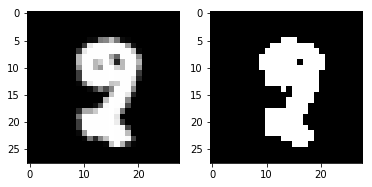

3


In [213]:
i = bias_index[180]
plt.subplot(1,2,1)
plt.imshow(train_shape[i+21000],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(image_valid[i],cmap='gray')
plt.show()
print(prediction_valid[i])

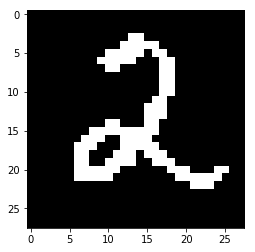

2


In [71]:
i = 2444
plt.imshow(image_test[i],cmap='gray')
plt.show()
print(prediction_test[i])

In [ ]:
# PCA

In [121]:
pca =PCA(n_components=200)
pca.fit(hog_training)
#var = pca.explained_variance_
hog_new = pca.transform(hog_training)
hog_valid_new = pca.transform(hog_valid)
hog_test_new = pca.transform(hog_test)

In [122]:
# SVM
#clf = svm.SVC(decision_function_shape='ovo')
clf_new = svm.SVC(C=100)
clf_new.fit(hog_new, yy_train) 

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [123]:
prediction_valid_new = clf_new.predict(hog_valid_new)

In [124]:
bias_new = [1.0 *(prediction_valid_new[i]==yy_valid[i]) for i in range(21000)]
accuracy_new = sum(bias_new)/21000
print(accuracy_new) 

0.98919047619


In [126]:
prediction_test_new = clf_new.predict(hog_test_new)

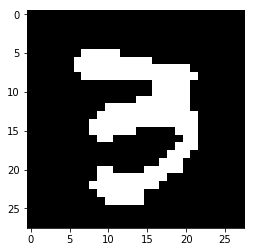

3


In [158]:
i = 4249
plt.imshow(image_test[i],cmap='gray')
plt.show()
print(prediction_test_new[i])

In [127]:
# Output
with open('predictions_reduction.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile)
    spamwriter.writerow(('ImageID', 'Label'))
    for i in range(28000):
        spamwriter.writerow((i+1 , prediction_test_new[i]))
csvfile.close()

In [159]:
len(test)

28000

In [180]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(hog_training,yy_train)
predict_knn_valid = knn.predict(hog_valid)

In [182]:
bias_knn = [1.0 *(predict_knn_valid[i]==yy_valid[i]) for i in range(21000)]
accuracy_knn = sum(bias_knn)/21000
print(accuracy_knn) 

0.985904761905
